In [25]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm

np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import seaborn as sns

In [34]:
covid = pd.read_csv('full_feature_covid.csv')
covid = covid.set_index('GEOID')

#clean up nans
covid = covid.fillna(0)

#break out categorical data
covid = pd.get_dummies(covid, columns=['DominantReligion','Region'])

#save georegion for later
geocols = ['Geographical_Point','Target_PctChg']
geo = covid[geocols]

#Drop categorical columns that won't help with our model
cols = ['County', 'State','Geographical_Point']
covid = covid.drop(cols, axis = 1)

#normalize data
covid['Target_PctChg'] = covid['Target_PctChg']/10
covid['Unempl_Rate'] = covid['Unempl_Rate']/100
covid['Median_HHI'] = covid['Median_HHI']/covid['Median_HHI'].sum()
covid['DensPerSqMile'] = covid['DensPerSqMile']/covid['DensPerSqMile'].sum()
covid['Avg_HH_Size'] = covid['Avg_HH_Size']/10
covid['Avg_Fam_Size'] = covid['Avg_Fam_Size']/10

covid.head()


,Target_PctChg,AgeUnder15,Age15to24,Age25to34,Age35to44,Age45to64,Age65to84,asAgeOver85,Married_Family,Avg_HH_Size,...,per_dem,per_gop,DominantReligion_Catholic,DominantReligion_Evangelical,DominantReligion_Mainline,DominantReligion_Other,Region_Midwest,Region_Northeast,Region_South,Region_West
GEOID,,,,,,,,,,,,,,,,,,,,,
10001,0.006987,0.129,0.136,0.138,0.115,0.244,0.158,0.020,0.458,0.259,...,0.511945,0.471232,1,0,0,0,0,0,1,0
10003,-0.017158,0.119,0.129,0.145,0.125,0.265,0.144,0.016,0.448,0.256,...,0.678065,0.307211,1,0,0,0,0,0,1,0
10005,-0.038147,0.104,0.092,0.096,0.099,0.271,0.264,0.026,0.538,0.239,...,0.438200,0.550668,1,0,0,0,0,0,1,0
1003,0.194856,0.121,0.116,0.109,0.128,0.265,0.195,0.019,0.513,0.268,...,0.224090,0.761714,0,1,0,0,0,0,1,0
1015,0.129139,0.117,0.127,0.132,0.127,0.257,0.164,0.016,0.461,0.248,...,0.298452,0.688484,0,1,0,0,0,0,1,0


In [32]:
X = covid.copy()
y = X.pop('Target_PctChg')

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y, test_size=0.2, random_state=1) 

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [17]:
from sklearn.metrics import mean_squared_error
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print('Mean-squared Error: {:0.4f}: '.format(mean_squared_error(predictions, test_labels)))
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [30]:

base_model = RandomForestRegressor(n_estimators=2000,
 min_samples_split=5,
 min_samples_leaf=4,
 max_features='sqrt',
 max_depth=None,
 bootstrap=False)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
best_model = RandomForestRegressor(n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=20, bootstrap=False)
best_model.fit(X_train, y_train)
best_accuracy = evaluate(best_model, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Mean-squared Error: 1.2719: 
Model Performance
Average Error: 0.7554 degrees.
Accuracy = -inf%.
Mean-squared Error: 1.2989: 
Model Performance
Average Error: 0.7627 degrees.
Accuracy = -inf%.
Improvement of nan%.
<ipython-input-30-107f24dc245c>:13: RuntimeWarning: invalid value encountered in double_scalars
  print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))


In [23]:
#decision tree 
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#pca = decomposition.PCA(n_components=5)
#pca.fit(X)
#X = pca.transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

dtm = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtm.fit(X_train,y_train)
y_hat = dtm.predict(X_test)
print('R-Squared on train dataset={}'.format(dtm.score(X_test, y_test)))
print('mean squared error: {}'.format(mean_squared_error(y_hat,y_test)))





R-Squared on train dataset=0.003593051714570028
mean squared error: 1.608222304906898


R-Squared::0.05424072027977407
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 100, 'min_samples_split': 10}


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

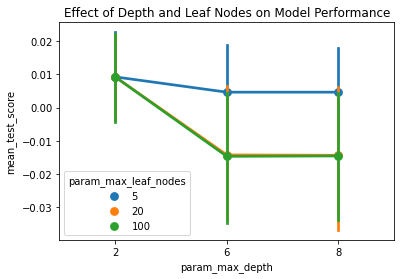

In [36]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X_train, y_train)

print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

#df = pd.DataFrame(data=grid_cv_dtm.cv_results_)
#df.head()

fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

In [37]:
#{'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 100, 'min_samples_split': 20}
dtm = DecisionTreeRegressor(criterion='mse',
                            max_depth=6,
                            min_samples_leaf=100,
                            min_samples_split=10,
                            max_leaf_nodes=100)

dtm.fit(X_train,y_train)
y_hat = dtm.predict(X_test)


print('R-Squared on train dataset={}'.format(dtm.score(X_test, y_test)))
print('mean squared error: {}'.format(mean_squared_error(y_hat,y_test)))



R-Squared on train dataset=0.16361929131417874
mean squared error: 1.3499365027682082


Mean squared error Linear Regression: 1.2970843170674198
mean squared error Decision Tree Regressor: 1.3937206098971118
mean squared error Random Forest Regressor: 1.3946972330144167
